In [30]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

## CT Features

In [494]:
df=pd.read_csv('ACS2020.csv')
df.head()

,Label,EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate,INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars),PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!18 to 64 years
0,"Census Tract 1, Bronx County, New York",NaN,NaN,NaN
1,Estimate,(X),"3,681",(X)
2,Percent,-,(X),-
3,"Census Tract 2, Bronx County, New York",NaN,NaN,NaN
4,Estimate,(X),"26,893",(X)


In [495]:
df.rename(columns={'EMPLOYMENT STATUS!!Civilian labor force!!Unemployment Rate': 'Unemployment_Rate','INCOME AND BENEFITS (IN 2020 INFLATION-ADJUSTED DOLLARS)!!Per capita income (dollars)': 'Per_Capita_Income',
                   'PERCENTAGE OF FAMILIES AND PEOPLE WHOSE INCOME IN THE PAST 12 MONTHS IS BELOW THE POVERTY LEVEL!!All people!!18 years and over!!18 to 64 years': '18-64_Poverty'}, inplace=True)

In [496]:
for x in np.linspace(0,6978,2327):
    df.at[x,'Unemployment_Rate']=df.at[x+2,'Unemployment_Rate']
    df.at[x,'Per_Capita_Income']=df.at[x+1,'Per_Capita_Income']
    df.at[x,'18-64_Poverty']=df.at[x+2,'18-64_Poverty']
df=df[(df['Label'] != '\xa0\xa0\xa0\xa0Estimate') & (df['Label'] != '\xa0\xa0\xa0\xa0Percent')]
df=df.reset_index().iloc[:,1:]
df['Boro']=df['Label']

In [497]:
df.shape

(2327, 5)

In [498]:
for i in range(len(df)):
    df.at[i,'Label']=float(df.iloc[i,0].split(' ')[2].split(',')[0])
    df.at[i,'Boro']=df.iloc[i,4].split(' ')[3]
df.head(2)

,Label,Unemployment_Rate,Per_Capita_Income,18-64_Poverty,Boro
0,1.0,-,"3,681",-,Bronx
1,2.0,10.8%,"26,893",23.9%,Bronx


In [499]:
df['BCT']=df['Label']*100
for i in range(len(df)):
    a=df.iloc[i,4]
    if a=='Bronx':
        df.at[i,'BCT']='2'+str(int(df.at[i,'BCT'])).zfill(6)
    elif a== 'Richmond':
        df.at[i,'BCT']='5'+str(int(df.at[i,'BCT'])).zfill(6)
    elif a== 'Kings':
        df.at[i,'BCT']='3'+str(int(df.at[i,'BCT'])).zfill(6)
    elif a== 'Queens':
        df.at[i,'BCT']='4'+str(int(df.at[i,'BCT'])).zfill(6)
    else:
        df.at[i,'BCT']='1'+str(int(df.at[i,'BCT'])).zfill(6)

df.at[1167,'BCT']='1000201'
df.at[1473,'BCT']='1031703'
df.at[1720,'BCT']='4030903'
df['BCT']=pd.to_numeric(df['BCT'])
df.head()

,Label,Unemployment_Rate,Per_Capita_Income,18-64_Poverty,Boro,BCT
0,1.0,-,"3,681",-,Bronx,2000100
1,2.0,10.8%,"26,893",23.9%,Bronx,2000200
2,4.0,4.6%,"38,792",2.8%,Bronx,2000400
3,16.0,8.8%,"26,227",15.1%,Bronx,2001600
4,19.01,4.4%,"36,697",24.6%,Bronx,2001901


## CT Population

In [500]:
po=pd.read_excel('Population.xlsx','2010, 2020, and Change')
po=po.iloc[:,2:]
po.head(3)

,Borough,GeoID,BCT2020,Total population
0,Bronx,36005000100,2000100,3772
1,Bronx,36005000200,2000200,4779
2,Bronx,36005000400,2000400,6272


In [501]:
ct=pd.merge(po,df,left_on='BCT2020',right_on='BCT',how='inner')
ct.head(2)

,Borough,GeoID,BCT2020,Total population,Label,Unemployment_Rate,Per_Capita_Income,18-64_Poverty,Boro,BCT
0,Bronx,36005000100,2000100,3772,1.0,-,"3,681",-,Bronx,2000100
1,Bronx,36005000200,2000200,4779,2.0,10.8%,"26,893",23.9%,Bronx,2000200


In [502]:
ct.shape

(2327, 10)

## Geodata for CT

In [570]:
geo=gpd.read_file('CTGeo.csv')
geo.head(2)

,the_geom,CTLabel,BoroCode,BoroName,CT2020,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,geometry
0,MULTIPOLYGON (((-74.04387761639944 40.69018767...,1,1,Manhattan,000100,1000100,,The Battery-Governors Island-Ellis Island-Libe...,MN0191,MN01,MN01 Financial District-Tribeca (CD 1 Equivalent),36061000100,11023.0485015,1844421.2457,None
1,MULTIPOLYGON (((-73.98449647076764 40.70950966...,2.01,1,Manhattan,000201,1000201,,Chinatown-Two Bridges,MN0301,MN03,MN03 Lower East Side-Chinatown (CD 3 Equivalent),36061000201,4754.49524739,972312.140355,None


In [571]:
geo.shape

(2325, 15)

In [572]:
geo['the_geom'] = gpd.GeoSeries.from_wkt(geo['the_geom'])
geo = gpd.GeoDataFrame(geo, geometry='the_geom')

In [573]:
geo.columns

Index(['the_geom', 'CTLabel', 'BoroCode', 'BoroName', 'CT2020', 'BoroCT2020',
       'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020', 'CDTANAME', 'GEOID',
       'Shape_Leng', 'Shape_Area', 'geometry'],
      dtype='object')

## Recognized Stations & Ridership

In [583]:
bike=pd.read_csv('Ridership by month by dow by stations.csv')
bike.head(2)

,MonthS,DOWS,start_station_id,start_station_id.1
0,1,0,2733.03,11
1,1,0,2782.02,8


In [584]:
station=pd.read_csv('2022station.csv').iloc[:,1:]
station.head(2)

,start_station_id,start_lng,start_lat
0,4488.09,-73.991160,40.688489
1,5616.08,-73.976831,40.727243


In [585]:
station=pd.merge(bike,stations,on='start_station_id',how='left')
station

,MonthS,DOWS,start_station_id,start_station_id.1,start_lng,start_lat
0,1,0,2733.03,11,-74.016562,40.633385
1,1,0,2782.02,8,-74.020005,40.635679
2,1,0,2832.03,9,-74.022141,40.637033
3,1,0,2872.02,7,-74.017820,40.637660
4,1,0,2883.03,5,-74.024714,40.638246
...,...,...,...,...,...,...
132252,12,6,8795.01,20,-73.885340,40.879350
132253,12,6,8795.03,3,-73.884755,40.877964
132254,12,6,8799.01,22,-73.891920,40.878120
132255,12,6,8811.01,1,-73.886065,40.880294


<AxesSubplot:>

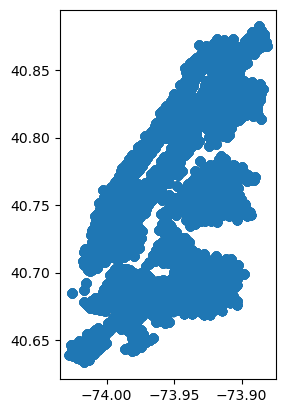

In [586]:
station=gpd.GeoDataFrame(station, geometry=gpd.points_from_xy(station.start_lng, station.start_lat))
station.plot()

In [587]:
geo=geo.set_crs('epsg: 4326')
station=station.set_crs('epsg: 4326')

Text(16.810638138155504, 0.5, 'Latitude')

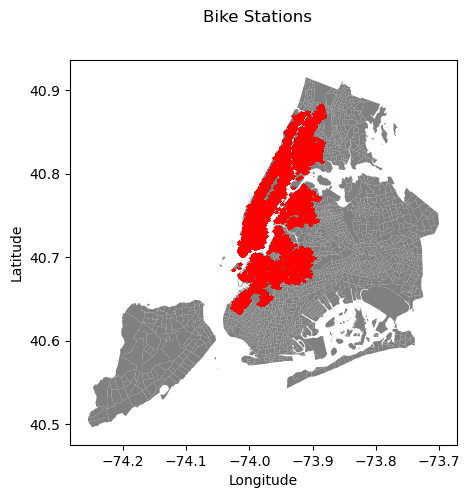

In [588]:
fig, ax = plt.subplots(figsize=(5,5))
geo.plot(ax=ax, facecolor='Grey')
station.plot(ax=ax, marker = '*', color='red', markersize=2);
fig.suptitle('Bike Stations', fontsize=12)
ax.set_xlabel('Longitude', fontsize=10)
ax.set_ylabel('Latitude', fontsize='medium')

## Inner Merge the Features

In [606]:
station_ct=gpd.sjoin(station,geo,how='left')
station_ct.rename(columns={'start_station_id':'station_ID','start_station_id.1':'Ridership',
                             'start_lng':'Longitude','start_lat':'Latitude'},inplace=True)
station_ct.head(2)

,MonthS,DOWS,station_ID,Ridership,Longitude,Latitude,geometry_left,index_right,CTLabel,BoroCode,...,BoroCT2020,CDEligibil,NTAName,NTA2020,CDTA2020,CDTANAME,GEOID,Shape_Leng,Shape_Area,geometry_right
0,1,0,2733.03,11,-74.016562,40.633385,POINT (-74.01656 40.63338),1484,126,3,...,3012600,,Bay Ridge,BK1001,BK10,BK10 Bay Ridge-Dyker Heights (CD 10 Approximat...,36047012600,7452.74935348,2553793.86824,None
1,1,0,2782.02,8,-74.020005,40.635679,POINT (-74.02000 40.63568),1484,126,3,...,3012600,,Bay Ridge,BK1001,BK10,BK10 Bay Ridge-Dyker Heights (CD 10 Approximat...,36047012600,7452.74935348,2553793.86824,None


In [607]:
station_ct.columns

Index(['MonthS', 'DOWS', 'station_ID', 'Ridership', 'Longitude', 'Latitude',
       'geometry_left', 'index_right', 'CTLabel', 'BoroCode', 'BoroName',
       'CT2020', 'BoroCT2020', 'CDEligibil', 'NTAName', 'NTA2020', 'CDTA2020',
       'CDTANAME', 'GEOID', 'Shape_Leng', 'Shape_Area', 'geometry_right'],
      dtype='object')

In [608]:
station_ct=station_ct[['MonthS', 'DOWS','station_ID', 'Ridership', 'Longitude', 'Latitude',
       'BoroName', 'BoroCT2020']]

In [611]:
station_ct.shape

(132257, 9)

## Groupby to Get Total Ridership

In [615]:
ridership_ct=station_ct.groupby(['BoroCT2020','MonthS', 'DOWS']).sum()[['Ridership']].reset_index()

/var/folders/87/xq0l9ml563jg73g4rvyqn4xw0000gn/T/ipykernel_16956/2830590393.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ridership_ct=station_ct.groupby(['BoroCT2020','MonthS', 'DOWS']).sum()[['Ridership']].reset_index()


In [616]:
ct

,Borough,GeoID,BCT2020,Total population,Label,Unemployment_Rate,Per_Capita_Income,18-64_Poverty,Boro,BCT
0,Bronx,36005000100,2000100,3772,1.0,-,"3,681",-,Bronx,2000100
1,Bronx,36005000200,2000200,4779,2.0,10.8%,"26,893",23.9%,Bronx,2000200
2,Bronx,36005000400,2000400,6272,4.0,4.6%,"38,792",2.8%,Bronx,2000400
3,Bronx,36005001600,2001600,5795,16.0,8.8%,"26,227",15.1%,Bronx,2001600
4,Bronx,36005001901,2001901,2292,19.01,4.4%,"36,697",24.6%,Bronx,2001901
...,...,...,...,...,...,...,...,...,...,...
2322,Staten Island,36085030302,5030302,6669,303.02,6.3%,"30,035",15.5%,Richmond,5030302
2323,Staten Island,36085031901,5031901,3262,319.01,14.9%,"18,579",28.6%,Richmond,5031901
2324,Staten Island,36085031902,5031902,5500,319.02,2.8%,"28,720",19.4%,Richmond,5031902
2325,Staten Island,36085032300,5032300,1233,323.0,0.7%,"49,730",16.2%,Richmond,5032300


## Merge Ridership and Features

In [619]:
ridership_ct['BoroCT2020']=pd.to_numeric(ridership_ct['BoroCT2020'])
features_bike=pd.merge(ridership_ct, ct, left_on='BoroCT2020',right_on='BCT2020', how='left')
features_bike

,BoroCT2020,MonthS,DOWS,Ridership,Borough,GeoID,BCT2020,Total population,Label,Unemployment_Rate,Per_Capita_Income,18-64_Poverty,Boro,BCT
0,1000201,1,0,228,Manhattan,3.606100e+10,1000201.0,2012.0,2.01,5.1%,"13,405",29.1%,New,1000201.0
1,1000201,1,1,195,Manhattan,3.606100e+10,1000201.0,2012.0,2.01,5.1%,"13,405",29.1%,New,1000201.0
2,1000201,1,2,230,Manhattan,3.606100e+10,1000201.0,2012.0,2.01,5.1%,"13,405",29.1%,New,1000201.0
3,1000201,1,3,229,Manhattan,3.606100e+10,1000201.0,2012.0,2.01,5.1%,"13,405",29.1%,New,1000201.0
4,1000201,1,4,191,Manhattan,3.606100e+10,1000201.0,2012.0,2.01,5.1%,"13,405",29.1%,New,1000201.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59272,4059100,12,2,136,Queens,3.608106e+10,4059100.0,5226.0,591.0,3.7%,"32,759",6.9%,Queens,4059100.0
59273,4059100,12,3,187,Queens,3.608106e+10,4059100.0,5226.0,591.0,3.7%,"32,759",6.9%,Queens,4059100.0
59274,4059100,12,4,151,Queens,3.608106e+10,4059100.0,5226.0,591.0,3.7%,"32,759",6.9%,Queens,4059100.0
59275,4059100,12,5,162,Queens,3.608106e+10,4059100.0,5226.0,591.0,3.7%,"32,759",6.9%,Queens,4059100.0


In [620]:
features_bike.columns

Index(['BoroCT2020', 'MonthS', 'DOWS', 'Ridership', 'Borough', 'GeoID',
       'BCT2020', 'Total population', 'Label', 'Unemployment_Rate',
       'Per_Capita_Income', '18-64_Poverty', 'Boro', 'BCT'],
      dtype='object')

In [623]:
features_bike=features_bike[['BoroCT2020','MonthS', 'DOWS', 'Ridership', 'Borough',
       'Total population', 'Unemployment_Rate',
       'Per_Capita_Income', '18-64_Poverty']]
features_bike.rename(columns={'BoroCT2020':'BCT_Code'},inplace=True)

/var/folders/87/xq0l9ml563jg73g4rvyqn4xw0000gn/T/ipykernel_16956/889471191.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_bike.rename(columns={'BoroCT2020':'BCT_Code'},inplace=True)


In [624]:
features_bike

,BCT_Code,MonthS,DOWS,Ridership,Borough,Total population,Unemployment_Rate,Per_Capita_Income,18-64_Poverty
0,1000201,1,0,228,Manhattan,2012.0,5.1%,"13,405",29.1%
1,1000201,1,1,195,Manhattan,2012.0,5.1%,"13,405",29.1%
2,1000201,1,2,230,Manhattan,2012.0,5.1%,"13,405",29.1%
3,1000201,1,3,229,Manhattan,2012.0,5.1%,"13,405",29.1%
4,1000201,1,4,191,Manhattan,2012.0,5.1%,"13,405",29.1%
...,...,...,...,...,...,...,...,...,...
59272,4059100,12,2,136,Queens,5226.0,3.7%,"32,759",6.9%
59273,4059100,12,3,187,Queens,5226.0,3.7%,"32,759",6.9%
59274,4059100,12,4,151,Queens,5226.0,3.7%,"32,759",6.9%
59275,4059100,12,5,162,Queens,5226.0,3.7%,"32,759",6.9%


In [625]:
features_bike.to_csv('Ridership and Features.csv')